In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
import math

## Load Dataset

In [2]:
df = pd.read_csv("../DataSets/bitcoin_prices2.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df_chart = df.copy()
df

,timestamp,-1min,-2min,-3min,-4min,-5min,-6min,-7min,-8min,-9min,...,-45min,-46min,-47min,-48min,-49min,-50min,MA7,MA25,MA50,price
0,2023-04-07 04:11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28036.40
1,2023-04-07 04:12:00,28036.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28037.03
2,2023-04-07 04:13:00,28037.03,28036.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28036.99
3,2023-04-07 04:14:00,28036.99,28037.03,28036.40,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28038.37
4,2023-04-07 04:15:00,28038.37,28036.99,28037.03,28036.40,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28039.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,2023-04-08 04:07:00,28041.29,28038.34,28033.28,28031.48,28030.91,28030.94,28031.78,28027.80,28021.88,...,27955.59,27953.45,27948.29,27947.63,27952.08,27959.32,28034.002857,28015.0840,28004.1144,28043.27
1437,2023-04-08 04:08:00,28043.27,28041.29,28038.34,28033.28,28031.48,28030.91,28030.94,28031.78,28027.80,...,27954.55,27955.59,27953.45,27948.29,27947.63,27952.08,28035.644286,28016.6264,28005.7934,28045.22
1438,2023-04-08 04:09:00,28045.22,28043.27,28041.29,28038.34,28033.28,28031.48,28030.91,28030.94,28031.78,...,27955.30,27954.55,27955.59,27953.45,27948.29,27947.63,28037.684286,28018.2200,28007.6562,28042.44
1439,2023-04-08 04:10:00,28042.44,28045.22,28043.27,28041.29,28038.34,28033.28,28031.48,28030.91,28030.94,...,27969.00,27955.30,27954.55,27955.59,27953.45,27948.29,28039.331429,28019.7508,28009.5524,28043.62


## Dataset Summary

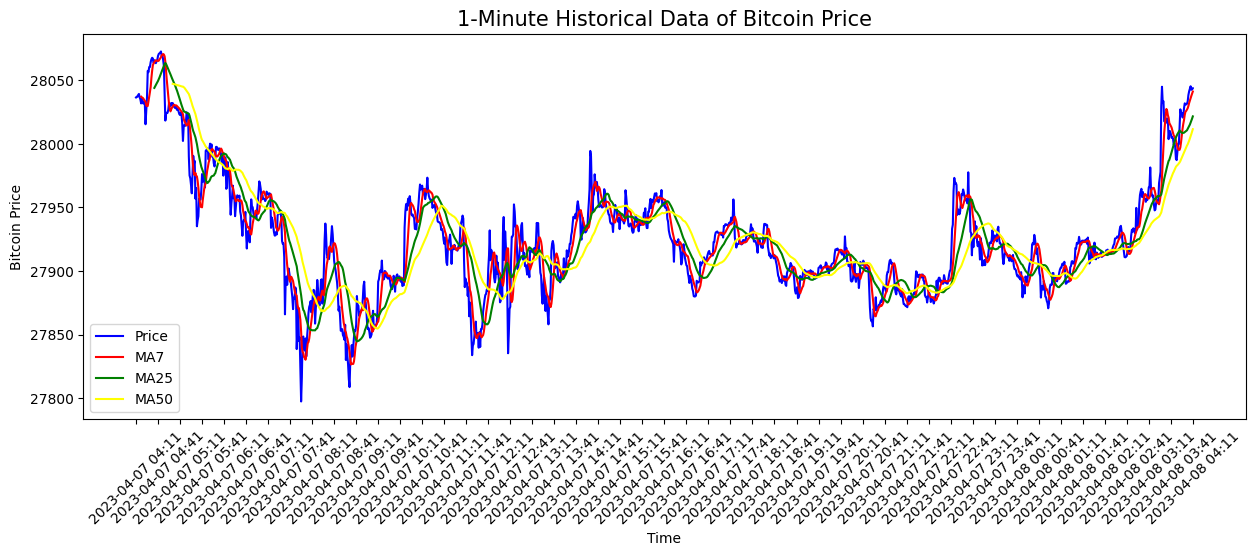

In [3]:
df_chart['timestamp'] = pd.to_datetime(df_chart['timestamp'])
df_chart.set_index('timestamp', inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df_chart.index, df_chart['price'], color='blue', label='Price')
plt.plot(df_chart.index, df_chart['MA7'], color='red', label='MA7')
plt.plot(df_chart.index, df_chart['MA25'], color='green', label='MA25')
plt.plot(df_chart.index, df_chart['MA50'], color='yellow', label='MA50')
plt.title('1-Minute Historical Data of Bitcoin Price', fontsize=15)
plt.ylabel('Bitcoin Price')
plt.xlabel('Time')
plt.legend()

tick_values = pd.date_range(start=df_chart.index[0], end=df_chart.index[-1], freq='30T')
tick_labels = [date.strftime('%Y-%m-%d %H:%M') for date in tick_values]
plt.xticks(tick_values, tick_labels, rotation=45)

plt.show()

## Set Features and Target

In [4]:
# drop the timestamp column, NaN rows
df = df.drop(df.index[:50])
df.drop(['timestamp'], axis=1, inplace=True)

In [5]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [6]:
X = df[:, :53]
y = df[:, -1]

In [7]:
X

array([[0.93980473, 0.94694586, 0.93677883, ..., 0.94458386, 1.        ,
        1.        ],
       [0.94670378, 0.93980473, 0.94694586, ..., 0.94968947, 0.99345825,
        0.99954386],
       [0.93645606, 0.94670378, 0.93980473, ..., 0.95148675, 0.98656267,
        0.99875836],
       ...,
       [1.        , 0.99213266, 0.98414427, ..., 0.98424384, 0.84414683,
        0.79504049],
       [0.98878399, 1.        , 0.99213266, ..., 0.9919189 , 0.85158674,
        0.80489156],
       [0.99354474, 0.98878399, 1.        , ..., 1.        , 0.86024557,
        0.81479665]])

In [8]:
y

array([0.94670378, 0.93645606, 0.93681917, ..., 0.98878399, 0.99354474,
       0.99354474])

## Split, Scale and Reshape Data

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape (X_test, (X_test.shape[0], X_test.shape[1], 1))

## Sequential model

In [11]:
model = Sequential ()
model. add(LSTM(units = 50, return_sequences= True, input_shape = (X_train.shape [1], 1)))
model. add (Dropout (0.2))
model. add (LSTM(units = 50, return_sequences= True))
model. add (Dropout (0.2))
model. add(LSTM(units = 50, return_sequences= True))
model. add(Dropout (0.2))
model.add(LSTM(units = 50))
model.add(Dropout (0.2))
model.add(Dense (units=1))

def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])

## Summary

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 53, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 53, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 53, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 53, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 53, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 53, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

## Train

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[lr_scheduler], verbose=1)

Epoch 1/50


2023-04-08 08:43:20.133743: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


31/31 [==============================] - 7s 83ms/step - loss: 0.0580 - accuracy: 0.0010 - val_loss: 0.0222 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 2/50
31/31 [==============================] - 2s 53ms/step - loss: 0.0205 - accuracy: 0.0010 - val_loss: 0.0206 - val_accuracy: 0.0024 - lr: 0.0100
Epoch 3/50
31/31 [==============================] - 2s 52ms/step - loss: 0.0175 - accuracy: 0.0010 - val_loss: 0.0142 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 4/50
31/31 [==============================] - 2s 59ms/step - loss: 0.0186 - accuracy: 0.0010 - val_loss: 0.0172 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 5/50
31/31 [==============================] - 2s 59ms/step - loss: 0.0162 - accuracy: 0.0010 - val_loss: 0.0164 - val_accuracy: 0.0024 - lr: 0.0100
Epoch 6/50
31/31 [==============================] - 2s 60ms/step - loss: 0.0148 - accuracy: 0.0010 - val_loss: 0.0118 - val_accuracy: 0.0024 - lr: 0.0100
Epoch 7/50
31/31 [==============================] - 2s 59ms/step - loss: 0.

In [ ]:
# model.save('model_002.h5')
# loaded_model = keras.models.load_model('model_002.h5')

## Evaluate

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
error_rates = (y_test.values.reshape(-1, 1) - y_pred) / y_test.values.reshape(-1, 1) * 100
average_error_rate = np.sum(error_rates)/len(error_rates)
plt.plot(error_rates)
plt.text(120,-55, average_error_rate, fontsize = 22, bbox = dict(facecolor = 'red', alpha = 0.3))
plt.title('Error Rate')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

In [ ]:
error_rates = (y_test.reshape(-1, 1) - y_pred) / y_test.reshape(-1, 1) * 100
average_error_rate = np.sum(error_rates)/len(error_rates)
plt.plot(error_rates)
plt.text(120,-55, average_error_rate, fontsize = 22, bbox = dict(facecolor = 'red', alpha = 0.3))
plt.title('Error Rate')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

In [ ]:
plt.scatter(y_test.index, y_test, color='red', label='Real Price', s=3)
plt.scatter(y_test.index, y_pred, color='blue', label='Predicted Price', s=3)
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Define y_test_index with row labels
y_test_index = range(len(y_test))

# Convert numpy arrays to pandas series
y_test_series = pd.Series(y_test.reshape(-1,), index=y_test_index)
y_pred_series = pd.Series(y_pred.reshape(-1,), index=y_test_index)

# Plot scatter plot
plt.scatter(y_test_series.index, y_test_series, color='red', label='Real Price', s=3)
plt.scatter(y_pred_series.index, y_pred_series, color='blue', label='Predicted Price', s=3)
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
